### problem setting


In [54]:
from scipy.sparse import *
import scipy.sparse.linalg
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

tol = 1e-10

### graph weight matrix
in our problem, the graph weight matrix is defined as the interaction flow between grids
here in the code we just consider the knearest grid, i.e. the top k grids that have the strongest flow 

In [45]:
M = 10000
#we first try out the interaction data of the first day
d1 = load_npz('../../data/interim/adj-sparse/MItoMI-2013-11-01.npz')

#then reconstruct a kNN graph arranged on a 2D grid
def graph_grid(d1,k = 20):
    
    #construct a grid
    m = np.int(np.sqrt(M))
    x = np.linspace(0,1,m)
    y = np.linspace(0,1,m)
    xx, yy = np.meshgrid(x,y)
    z = np.empty((M,2))
    
    #use the interaction between to construct the kNN graph

    datamatrix = d1.toarray()[1:,1:]
    idx = np.argsort(-datamatrix)[:,:k]
    datamatrix = -np.sort(-datamatrix)
    datamatrix = datamatrix[:,:k]
    
    #coo matrix
    I = np.arange(0,M).repeat(k)
    J = idx.reshape(M*k)
    V = datamatrix.reshape(M*k)
    W = scipy.sparse.coo_matrix((V,(I,J)),shape = (M,M))
    
    return graph_regularize(W,directed = False)   

def graph_regularize(W, selfConnection = True, directed = True):
    if not selfConnection:
        W.setdiag(0)
    if not directed:
        bigger = W.T > W
        W = W - W.multiply(bigger) + W.T.multiply(bigger)
        del bigger
        assert np.abs(W - W.T).mean() < tol
    
    #CSR sparse matrix format for efficient multiplications
    W = W.tocsr()
    W.eliminate_zeros()
    
    return W

In [47]:
k = 20
W = graph_grid(d1)
print("{} > {} edges".format(W.nnz, M*k))

331116 > 200000 edges


#### graph Laplacian
$$L^{unnormalized} = D - W$$
$$L^{normalized} = I - D^{\frac{-1}{2}}WD^{\frac{-1}{2}}$$

- Normalized graph laplacian has a bounded spectrum $0\leq \lambda \leq 2$
- computed by the implicitly restarted lanczos method

In [52]:
def laplacian(W,normalized = True):
    #return the laplacian of the weigh matrix
    d = W.sum(axis  = 0)
    
    #Laplacian matrix
    if not normalized:
        D = scipy.sparse.diags(d.A.squeeze(),0)
        L = D - W
    else:
        d = 1 / np.sqrt(d)
        D = scipy.sparse.diags(d.A.squeeze(),0)
        I = scipy.sparse.identity(M)
        L = I - D*W*D
        
    #upper-bound on the spectrum
    lmax = scipy.sparse.linalg.eigs(L, k = 1, which = 'LM', return_eigenvectors = False)[0]
    if normalized:
        assert lmax <= 2
        lmax = 2
    
    return L,lmax

In [55]:
import time
t_start = time.process_time()
LL, lmax = laplacian(W, True)
print('Execution time:{:1.0f}ms'.format((time.process_time() - t_start)*1000))
assert np.abs(LL - LL.T).mean() < tol

Execution time:78ms


### Fourier basis
$L = U^{T}\Lambda U$ where $\Lambda$ is a diagonal matrix of eigenvalues

In [57]:
def fourier(L):
    def sort(lamb, U):
        idx = lamb.argsort()
        return lamb[idx], U[:,idx]
    
    t_start = time.process_time()
    lamb, U = np.linalg.eig(L.toarray())
    lamb, U = sort(lamb, U)
    print('Execution time:{:1.0f}ms'.format((time.process_time() - t_start) * 1000))
    
    #Orthonormal basis: all basis vectors are of length one (unit energy)
    np.testing.assert_allclose(np.linalg.norm(U,axis = 0), np.ones(M))
    
    '''
    I don't know why there is the row norm reaching  1.11.. maybe because of the large computation complexity and thus lead to the decline in precision?
    np.testing.assert_allclose(np.linalg.norm(U,axis = 1), np.ones(M))
    '''
    
    if M <= 100: # compare the result of four algo,because of the computational complexity
        lamb_, U_ = np.linalg.eigh(L.toarray())
        np.testing.assert_allclose(lamb_, lamb, atol = tol)
        np.testing.assert_allclose(np.abs(U_), np.abs(U), atol = tol)
        
        lamb_, U_ = scipy.sparse.linalg.eigs(L, k = M - 2)
        lamb_, U_ = sort(lamb_,U_)
        np.testing.assert_allclose(lamb[:-2], lamb_, atol = tol)
        np.testing.assert_alloclose(np.abs(U[:,:-2]), np.abs(U_), atol = tol)
        
        lamb_, U_ = scipy.sparse.linalg.eigsh(L, k = M-1, which = 'SM')
        np.testing.assert_allclose(lamb[:-1],lamb_,atol = tol)
        np.testing.assert_allclose(np.abs(U[:,:-1]), np.abs(U_), atol = tol)
        
    return lamb, U

lamb, U = fourier(LL)

Execution time:1112969ms


Spectrum:[3.13e-09+0.00e+00j, 1.55e+00+0.00e+00j]


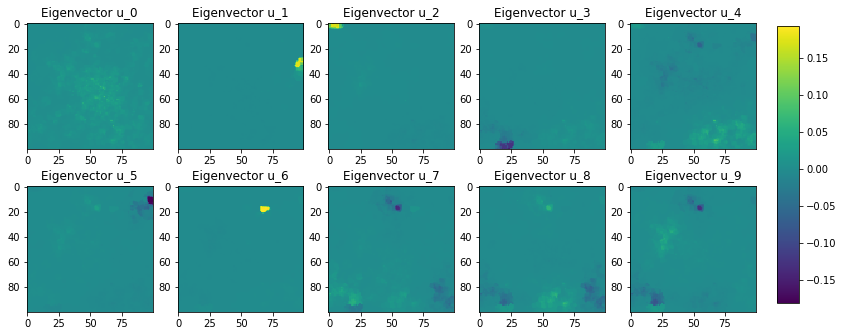

In [77]:
print('Spectrum:[{:1.2e}, {:1.2e}]'.format(lamb[0],lamb[-1]))
'''
the precision again is the problem
np.testing.assert_allclose(lamb[0],0,atol = tol)
'''
assert lamb[-1] <= lmax + tol

def plot_eigenvectors(U,nrows, ncols,reverse = False):
    fig, axes = plt.subplots(nrows, ncols, figsize = (15,5.5))
    m = np.int(np.sqrt(M))
    n = nrows * ncols
    vmin, vmax = np.real(U[:,:n].min()), np.real(U[:,:n].max())
    
    for i,ax in enumerate(axes.flat):
        if reverse:
            i = -i
        x = np.reshape(U[:,i],(m,m))
        im = ax.imshow(np.real(x), vmin = vmin, vmax = vmax)
        ax.set_title('Eigenvector u_{}'.format(i))
        
    fig.subplots_adjust(right = 0.8)
    cax = fig.add_axes([0.82,0.16,0.02,0.7])
    fig.colorbar(im, cax = cax)
    plt.show()

plot_eigenvectors(U,2,5)

we can see that the eigenvectors corresponding to the largest eigenvalues is not as smooth as the ones from the front, and why? what do the spectrum in this context mean?

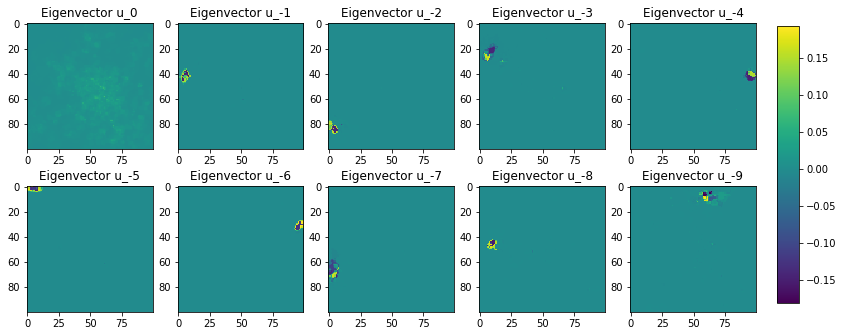

In [78]:
plot_eigenvectors(U,2,5,True)

### Ground truth graph filter
Linear mapping $f(x_i,c) = UCU^Tx_i$, C is the diagonal matrix $C = (c)$, i.e. $c = C1_M$
 
- Parametrized low-pass filter coefficients $(c_{gt})_i = \operatorname{e}^{-t\lambda_i}$
- Random filter coefficients $c_{gt}\sim N_m(0,1)$

In [79]:
lamb

array([3.12703991e-09+0.j, 7.22673712e-03+0.j, 1.37592196e-02+0.j, ...,
       1.49851873e+00+0.j, 1.50288634e+00+0.j, 1.54596436e+00+0.j])

In [87]:
# what's the exact meaning of those filter?
gg = lambda x : np.minimum(np.array(x < lmax/2) + 0.5, 1)
ll = gg(lamb)
ll

array([1. , 1. , 1. , ..., 0.5, 0.5, 0.5])

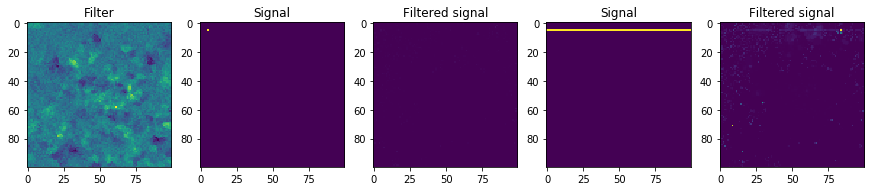

Filter energy E = {:.1f}.format(E)


In [90]:
def gen_filter(type = 'step', t = 2):
    if type is 'random':
        return np.random.normal(0,1,M),None
    elif type is 'step':
        g = lambda x : np.minimum(np.array(x < lmax/2) + 0.5, 1)
    elif type is 'sin':
        g = lambda x : np.sin(t * (x - 2) **2)
    elif type is 'heat':
        g = lambda x: np.exp(-t * x)
    elif type is 'hat':
        g = lambda x: t * x * np.exp(-x**2)
    return g(lamb),g

c_g, g = gen_filter('step', 6)

def filter_full(X, c):
    '''Filter X with a full spectral domain filter.'''
    return U @ np.diag(c) @ U.T @ X 

def plot_filtering(*args):
    m = np.int(np.sqrt(M))
    c = gen_filter(*args)[0]
    
    x1 = np.zeros((m,m))
    x2 = np.zeros((m,m))
    # x here is for signal menifestion
    x1[5,5] = 1
    x2[5,:] = 1
    x1.shape = M
    x2.shape = M
    
    fig,axes = plt.subplots(1,5,figsize=(15,5))
    axes[0].imshow(np.real(U @ c).reshape((m,m)))
    axes[0].set_title('Filter')
    
    for i,x in enumerate([x1,x2]):
        axes[2*i+1].imshow(x.reshape((m,m)), vmin = 0, vmax = 1)
        axes[2*i+1].set_title('Signal')
        y = np.real(filter_full(x,c))
        axes[2*i+2].imshow(y.reshape((m,m)), vmin = 0, vmax = 1)
        axes[2*i+2].set_title('Filtered signal')
    plt.show()
    
plot_filtering('heat', 3)
#Parseval (energy preservation)
E = np.linalg.norm(c_g)**2
print('Filter energy E = {:.1f}.format(E)')

#not equal
#AssertionError: 
#Not equal to tolerance rtol=1e-07, atol=0

#(mismatch 100.0%)
# x: array(6244.49262)
# y: array(6321.25)
#
#np.testing.assert_allclose(np.linalg.norm(U @ c_g) ** 2, E)

we can see that the noise in the signal is filtered in the two example

### Graph signals
 - Random input signals $X \sim N_{M*N}(0,1)$
     - Low pass signals?
 - Noisy target signals $y_i = f(x_i,c_{gt}+N_M(0,\epsilon))$

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


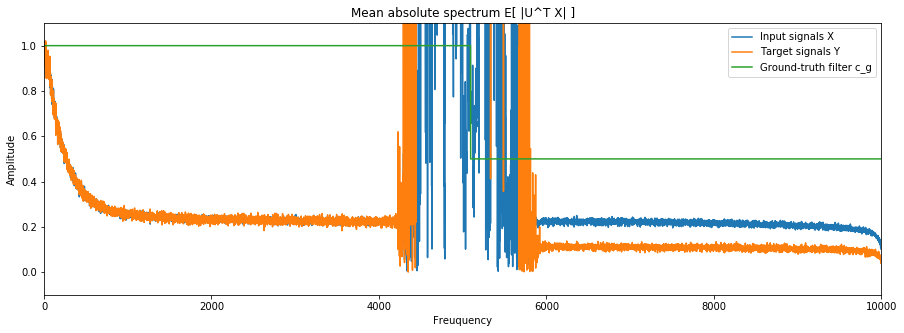

In [92]:
N = 200 #signals, i.e. the number of sample
eps = 0.1 # noise

def gen_signal(spectral_mean):
    Xf = np.empty((M,N))
    for m in range(M):
        a = spectral_mean[m]
        Xf[m,:] = np.random.normal(a,a/2,N)
    return U @ Xf

# what's the difference between the following two X ??
X = np.random.normal(0,1,(M,N))
X = gen_signal(np.exp(-1.5*lamb))
#np.testing.assert_allclose(filter_full(X, np.ones(M)), X, atol = tol)
#Not equal to tolerance rtol=1e-07, atol=1e-10

#(mismatch 99.95875%)
# x: array([13.469989-2.904814e-01j, 16.312434+2.985658e-01j,
#       12.290843-5.441609e-01j, ..., -0.366217+1.689504e-06j,
#       -0.756924+2.914161e-06j, -0.327847+1.971057e-06j])
# y: array([ 0.643689-2.376791e-03j,  0.346506+4.811559e-04j,
#        0.316942-5.269070e-03j, ..., -0.36598 -1.189513e-05j,
#       -0.756807-4.669012e-07j, -0.327713-5.734431e-06j])

Y = filter_full(X,c_g) + np.random.normal(0,eps, (M,N) if eps > 0 else 0)

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
ax.plot(np.abs(np.mean((U.T @ X), axis = 1)), label = 'Input signals X')
ax.plot(np.abs(np.mean((U.T @ Y), axis = 1)), label = 'Target signals Y')
ax.plot(c_g, label = 'Ground-truth filter c_g')
ax.legend()
ax.set_title('Mean absolute spectrum E[ |U^T X| ]')
ax.set_xlabel('Freuquency')
ax.set_ylabel('Amplitude')
ax.set_xlim(0,M-1)
ax.set_ylim(-.1,1.1)
plt.show()

filter learning should first transform the signals to **spectral domain** 

### Non-parameterized filter learning
 ##### Loss function
 - Loss function $L = \frac{1}{N}\sum_{i = 1}^{N}\Vert f(x_i,c) - y_i \Vert_2^2 = \frac{1}{N} \Vert UCU^X - Y\Vert_F^2$
     - Spectral domain: $L = \frac{1}{N}\Vert CU^TX - U^TY\Vert_F^2$
     - Independant coefficients $L = \frac{1}{N}\sum_{i = 1}^M\Vert c_i(U^TX)_i - (U^TY)_i\Vert_2^2$
     - Convex and smooth w.r.t c
     
 - Gradient:
     - Independent coefficients: $\nabla_{c_i}L = \frac{2}{N}(c_i(U^TX)_i - (U^TY)_i)(X^TU)_i$
     - $\nabla_cL = \frac{2}{N}(U^X \odot(c \odot U^T X - U^Y))1_N$
 - Optimization $c^* = \operatorname{arg min}_{c}L{c}$


In [110]:
def L(c):
    M,N = X.shape
    return np.linalg.norm(filter_full(X,c) - Y, ord = 'fro') ** 2 /N
#np.testing.assert_alloclos(L(c_g),M*eps**2,5e-2)

def dL(X,Y,c, variant = None):
    M,N = X.shape
    Xh = U.T @ X
    Yh = U.T @ Y
    #Speed v3 >> v1 > v2
    if variant is 1:
        return  np.real(2 /  N * np.diag((np.diag(c) @ Xh - Yh) @ Xh.T))
    elif variant is 2:
        dc = np.empty(M)
        for i in range(M):
            dc[i] = 2/N * (c[i] * Xh[i,:] - Yh[i,:]) @ Xh.T[:,i]
        return np.real(dc)
    else:
        #speed : .sum(axis = 1) is faster than * np.ones(N)
        return np.real(2 / N * ((c[:,np.newaxis] * Xh - Yh) * Xh).sum(axis = 1))
    #gradient should be null at the global minimum. With noise, c_g is not necessary the optim
    
if eps <= 0:
    np.testing.assert_allclose(dL(X,Y,c_g), 0 , atol = tol)
np.testing.assert_allclose(dL(X,Y,c_g), dL(X,Y,c_g,1))
#np.testing.assert_allclose(dL(X,Y,c_g), dL(X,Y,c_g,2))
#Not equal to tolerance rtol=1e-07, atol=0

#(mismatch 78.9%)
# x: array([-0.003729+6.032290e-11j,  0.018283-4.392813e-10j,
#        0.010281-1.715095e-09j, ...,  0.002704-6.714146e-11j,
#       0.000685+6.834423e-11j,  0.000623-3.395167e-11j])
#y: array([-0.003729,  0.018283,  0.010281, ...,  0.002704,  0.000685,
#        0.000623])

#### Optimiazeion: optimality condiction
- only possible because L is convex and smooth
- Optimality condiction $\nabla_cL = 0$ gives$(U^TX\odot U^TX)1_N\odot c = (U^X\odot U^TY)1_N$

In [111]:
t_start = time.process_time()
Xh = U.T @ X
Yh = U.T @ Y
c_o = (Xh * Yh).sum(axis = 1) / (Xh*Xh).sum(axis = 1)
print('Excution time:{:1.0f}ms'.format((time.process_time() - t_start)*1000))

#assert L(c_o) < L(c_g) + tol
assert np.linalg.norm(dL(X,Y,c_o)) < np.linalg.norm(dL(X,Y,c_g))
np.testing.assert_allclose(dL(X,Y,c_o), 0, atol = tol)
if eps <= 0:
    np.testing.assert_allclose(c_o, c_g, atol = tol)
    np.testing.assert_allclose(L(c_o), L(c_g), atol = tol)

Excution time:10469ms


#### Optimization: stochastic (mini-batch) gradient descent
- Works also for L which are non-smooth(sub-gradient) or non-convex
- idea: descend the gradient of the loss function
- efficiency: compute the gradient $nabla_cL$ with sub-set(mini-batch)of the training data
    - extreme case: one sample at a time. very inefficient
- update rule (gradient descent) $c^{n+1} = c^n - \lambda_n\nabla_xL$
- Note: objective(loss on training set) and error (on validation set) are usually evaluated after each epoch. The algorithm is thus stopped after a maximum number of epochs rather than iterations
- the convergence is O(n^{-2})
- hyper-parameters
    - learning rate(step size) \lambda_n. Bigger the batch size, the smaller the learning rate
        - trade off
            - Small:progress is steady but slow
            - Big: risks of osillations or divergence
        - There are tricks, e.g. vanishing step(like simulated annealing)
    - size of the mini batch
         - we want the one who minimizes the training time
         - trade off: should be limited by the availablee memory, somewhere around 100
             - larger is more stable, but computationnaly more expensive
             - smaller demands more accesses to memory, which is slow
             - larger exploits the parallelism of modern hardware architectures(SIMD on CPU GPU)
         - Extreme cases:
             - 1: stochastic gradient descent
             - N: gradient descent
         - Stopping criterion.
             - Convergence of the loss function L
             - Convergence of the parameters c
             - Maximum number of iterations

In [114]:
def sgd(c0, L, dL, learning_rate = .1, batch_size = 100, crit = 1e-3, maxit =100, window = 100):
    #stochastic (mini - batch ) gradient descent
    indices = []
    c = c0
    loss = [L(c)]
    conv = []
    
    def stop(loss):
        #stop after convergence of the loss
        if len(loss) > maxit:
            return True
         #the window is set to see if the loss is converging
        elif len(loss) >= 2 * window:
            avg1 = np.mean(loss[-window:])
            avg2 = np.mean(loss[-2*window : -window])
            return True if avg2 - avg1 < crit else Flase
        else:
            return False
        
    while not stop(loss):
        #be sure to have used all the samples before using one a second time
        if len(indices) < batch_size:
            new_indices = np.arange(N)
            np.random.shuffle(new_indices)
            indices.extend(new_indices)
        idx = indices[:batch_size]
        del indices[:batch_size]
        
        #shallow copy 
        c_last = c.copy()
        n = len(loss)
        c -= eval(learning_rate)*dL(X[:,idx], Y[:,idx], np.real(c))
        loss.append(L(c))
        conv.append(np.linalg.norm(c - c_last) / np.linalg.norm(c))
        
    return c, loss, conv

def rate(rate0, a, k):
    #Decaying learning rate w.r.t iteration k
    return rate0 / (1+ a * rate0 * k)

In [ ]:
def sgd_plot_convergence(c0, L, dL, params, crit, maxit):
    fig_loss = plt.figure(figsize = (15,5))
    fig_conv = plt.figure(figsize = (15,5))
    fig_rate = plt.figure(figsize = (15,5))
    ax_loss = fig_loss.add_subplot(1,1,1)
    ax_conv = fig_conv.add_subplot(1,1,1)
    ax_rate = fig_rate.add_subplot(1,1,1)
    
    c_sgd = []
    mlen = 0
    
    for param in params:
        t_start = time.process_time()
        c, loss, conv = sgd(c0.copy(), L, dL, param[0], param[1], crit, maxit)
        t = (time.process_time() - t_start) * 1000
        label = 'rate={}, size = {}, L(c) ={:1.2e}, |dL(c)| = {:1.2e}, conv={:1.2e}, time = {:1.0f}ms'.format(param[0],param[1],L(c), np.linalg.norm(dL(X,Y,c)), conv[-1],t)
        n = np.arange(1, len(conv)+1)
        ax_loss.plot(loss, label = label)
        ax_conv.loglog(n, conv, label = label)
        learning_rate = eval(param[0])
        if not isinstance(learning_rate, np.ndarray):
            learning_rate *= np.ones(len(n))
        ax_rate.plot(n, learning_rate, label = label)
        c_sgd.append(c)
        mlen = max(mlen, len(loss))
    
    n = np.arange(1,mlen)
    ax_conv.semilogy(n, 1/n**2, label = '0(n^-2)')
    
    for ax in ax_loss, ax_conv, ax_rate:
        ax.set_title('Convergence, M={}, N={}, eps={}'.format(M,N,eps))
        ax.set_xlabel('iteration n')
        ax.legend(loc = 'best')
    ax_loss.set_ylabel('loss L(c^n)')
    ax_conv.set_ylabel('coefficients convergence ||c^n - c^n -1|| / ||c^n||')
    ax_rate.set_ylabel('learning rate')
    ax_loss.set_xlim(0,mlen - 1)
    ax_conv.set_xlim(1,mlen - 1)
    ax_rate.set_xlim(1,mlen - 1)
    plt.show()
    
    return c_sgd

#learning rate and batch size
params = []
params.append(['0.2',1])
params.append(['0.2',5])
params.append(['0.2',50])
params.append(['0.2',100])
params.append(['0.6',100])
params.append(['(1*n)**-1',100])
params.append(['rate(.9,.1,n)', 100])
#random uniform initial weight
c0 = np.random.uniform(0,1,M)
c_s = sgd_plot_convergence(c0, L, dL, params, crit=1e-3, maxit = 100)


## Results: learning filters

Observations:
- Noise: why don't we find the same loss as the ground truth, but the same as linear programming?
    - The gradient was incorrectly set to $\nabla_cL = \frac{2}{N}U^TX(X^TUc - Y^TU1_M)$
- More samples, e.g. N = 2000: why don't we find the same loss as the linear program?
    - learning rate too high
- The spectral gap $\lambda _1$ is large for a random graph
- without noise, the recovered filter is exact

In [ ]:
def plot_filters(coeffs):
    fig = plt.figure(figsize = (15,5))
    ax = fig.add_subplot(1,1,1)
    for coeff in coeffs:
        c = eval(coeff)
        label = '{}:L={:1.2e},|dL| = {:1.2e}.format(coeff, L(c), np.linalg.norm(dL(X,Y,c)))'
        ax.plot(lamb, c, '.-', label = label)
    
    ax.set_xlim(lamb[0],lamb[-1])
    ax.set_title('Filter coefficients,M={},N={}, eps={}'.format(M,N,eps))
    ax.set_xlabel('frequency')
    ax.set_ylabel('amplitude')
    ax.legend(loc = 'best')

plot_filters(['c_s[4]','c_s[0]','c_o','c_g'])

### Parametrized filter learning: truncated Chebyshev expansion

- use a $K$ th orger polynomial approximation of the filter
- Less free parameters: $K << M$
- Good approximation for smooth, i.e. localized, filters.


#### Basic of chebyshev polynomials

- compute the chebyshev basis $T$ of order $K$
- This basis will allow us to construct and observe the filter from the inferred polynomial coefficients
- the figure shows that we indeed generate teh chebshev polynomials of the first kind

In [ ]:
K = 5
def cheby_basis(K,x):
    #return the chebyshev basis of order K (composed of the first K polynomials) evaluated at x
    #polynomials are generated by their recursive formulation
    
    #just consider the k-localized of each node, then T is of shape(M,K)
    T = np.empty((x.size,K))
    T[:,0] = np.ones(x.size)
    if K >= 2:
        T[:,1] = x
    for k in range(2,K):
        T[:,k] = 2*x*T[:,k -1] - T[:,k-2]
    #scaling to unit norm
    #T /= np.linalg.norm(T,axis = 0)
    return T

fig = plt.figure(figsize = (15,5))
ax = fig.add_subplot(1,1,1)
x = np.linspace(-1,1,100)
T = cheby_basis(K,x)
for k in range(K):
    ax.plot(x, T[:,k], label = 'T_{},E={:.1f}'.format(k,np.linalg.norm(T[:,k])**2))
ax.set_title('Chebyshev polynomials of the first kind')
ax.set_xlabel('x')
ax.set_ylabel('T_n(x)')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1.1)
ax.legend(loc = 'best')
plt.show()